## Импорты

In [24]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomRotation

from torch.optim.lr_scheduler import StepLR

import sys
import os
import logging
import matplotlib.pyplot as plt

from PIL import Image
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024D1DAB0E50>
Traceback (most recent call last):
  File "c:\Users\VVV\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\VVV\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
c:\Users\VVV\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Конфиг

In [37]:
# Конфигурация
EPOCHS = 70
BATCH_SIZE = 128
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CNN_MODEL = "cars70"
TRANSFER_MODEL = "transfer_cars"
APIS_PATH = "../src/apis.txt"  # Путь к API
DATASET_PATH = "../src/dataset" # Путь к папке с данными
LOG_DIR = "../logs/tensorboard/"  
RESULTS_DIR = "../results/models"  # Путь для сохранения модели

# Конфигурация для тестирования
MODEL_PATH = "../results/models/"  # Путь к сохраненной модели
TEST_IMAGE_FOLDER = "../data/test_cars"  # Путь к папке с тестовыми изображениями

In [3]:
# Преобразования изображений
TRANSFORMS = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(),      # Случайное горизонтальное отражение
    RandomRotation(10),          # Случайное вращение на ±10 градусов
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [18]:
# Конфигурация логирования
LOGGING_DIR = "../logs/train_cnn_model_logs"  
if not os.path.exists(LOGGING_DIR):
    os.makedirs(LOGGING_DIR)  

file_handler = logging.FileHandler(os.path.join(LOGGING_DIR, "train_cnn_model.log"))
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', handlers=[file_handler, logging.StreamHandler()])


## Сбор данных

In [4]:
import requests
import os
import time
import threading

def fetch_photos(queries):
    with open(APIS_PATH, 'r') as f:
        api_keys = [line.strip().split(' - ')[-1] for line in f.readlines()]
    
    per_page = 30 
    semaphore = threading.Semaphore(5)  # Ограничиваем одновременно выполняемые потоки до 3
    
    def download_photos(query):
        semaphore.acquire()
        try:
            save_dir = os.path.join('..', 'src', 'dataset', "-".join(query.split()))
            os.makedirs(save_dir, exist_ok=True)
            existing_files = os.listdir(save_dir) 

            start_page = (len(existing_files)) // per_page + 1  
            count = (start_page - 1) * per_page + 1 

            api_key_index = 0
            page = start_page

            while count < 2400:
                url = f'https://api.unsplash.com/search/photos?page={page}&per_page={per_page}&query={query}'
                headers = {
                    'Authorization': f'Client-ID {api_keys[api_key_index]}'
                }
                response = requests.get(url, headers=headers)
                if response.status_code == 200:
                    data = response.json()
                    photos = [result['urls']['regular'] for result in data['results']]
                    if not photos:
                        print(f'Нет больше фото для "{query}" на странице {page}')
                        break
                    print(f'Загружено {len(photos)} фото для "{query}" на странице {page}')
                    for photo_url in photos:
                        if count > 2400:
                            break
                        img_data = requests.get(photo_url).content
                        with open(os.path.join(save_dir, f'{count}.jpg'), 'wb') as handler:
                            handler.write(img_data)
                        count += 1
                    page += 1
                else:
                    print(f'Ошибка API ключа {api_keys[api_key_index]}, переключаюсь на следующий.')
                    api_key_index = (api_key_index + 1) % len(api_keys)
                    if api_key_index == 0:
                        print('Все API ключи исчерпаны.')
                        time.sleep(30)
        finally:
            semaphore.release()
    
    threads = []
    for query in queries:
        thread = threading.Thread(target=download_photos, args=(query,))
        threads.append(thread)
        thread.start()
    
    for thread in threads:
        thread.join()

queries = [
    'car',
    'boat',
    'plane',
    'train',
    'bicycle',
]

print(fetch_photos(queries))


None


In [ ]:
# Инициализация
dataset = ImageFolder(DATASET_PATH, transform=TRANSFORMS)
print(f"Классы: {dataset.classes}")
print(f"Число классов: {len(dataset.classes)}")

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
trash_size = len(dataset) - train_size - val_size - test_size

train_dataset, val_dataset, test_dataset, trash_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size, trash_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Классы: ['bicycle', 'boat', 'car', 'plane', 'train']
Число классов: 5


## Функции запуска

In [29]:
# Общая функция для тренировки и валидации
def run_epoch(model, data_loader, criterion, device, optimizer=None):
    """
    Обрабатывает одну эпоху для тренировки или валидации.

    :param model: Модель, которую нужно тренировать или валидировать
    :param data_loader: Даталоадер для данных (тренировочные или валидационные)
    :param criterion: Функция потерь
    :param device: Устройство (CPU или GPU)
    :param optimizer: Оптимизатор, если тренировка (по умолчанию None для валидации)
    :return: Потери и количество правильных предсказаний
    """
    model.train() if optimizer else model.eval()  
    epoch_loss, epoch_correct = 0, 0
    total_samples = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        logging.debug(f"Inputs are on device: {inputs.device}")

        
        # Если это тренировка, обнуляем градиенты и делаем шаг
        if optimizer:
            optimizer.zero_grad()

        outputs, features = model(inputs)
        loss = criterion(outputs, targets)

        # Если это тренировка, вычисляем градиенты и обновляем параметры
        if optimizer:
            loss.backward()
            optimizer.step()

        batch_size = inputs.size(0)
        epoch_loss += loss.item() * batch_size 
        epoch_correct += (outputs.argmax(1) == targets).sum().item()
        total_samples += batch_size  

    epoch_loss /= total_samples 
    epoch_acc = epoch_correct / total_samples  

    return epoch_loss, epoch_acc


# Функция для тренировки модели на одной эпохе
def train_epoch(model, train_loader, criterion, optimizer, device):
    return run_epoch(model, train_loader, criterion, device, optimizer)


# Функция для валидации модели на одной эпохе
def validate_epoch(model, val_loader, criterion, device):
    return run_epoch(model, val_loader, criterion, device)


# Функция для логирования метрик в TensorBoard
def log_metrics(writer, epoch, train_loss, val_loss, train_acc, val_acc):
    writer.add_scalars('Loss', {
        'train': train_loss,
        'val': val_loss
    }, epoch)
    writer.add_scalars('Accuracy', {
        'train': train_acc,
        'val': val_acc
    }, epoch)
    logging.info(
        f"Epoch {epoch + 1}/{EPOCHS}, "
        f"Train Loss: {train_loss:.4f}, "
        f"Val Loss: {val_loss:.4f}, "
        f"Train Acc: {train_acc:.4f}, "
        f"Val Acc: {val_acc:.4f}"
    )


# Функция для сохранения модели
def save_model(model, save_path):
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR) 
    torch.save(model.state_dict(), save_path) 
    logging.info(f"Model saved to {save_path}")


# Основная функция тренировки
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, writer, device, name):
    best_val_acc = 0.0
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        log_metrics(writer, epoch, train_loss, val_loss, train_acc, val_acc)  
        
        scheduler.step()
        
        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_save_path = os.path.join(RESULTS_DIR, f"best_model_{name}.pth")
            save_model(model, model_save_path)
        
        
        # if torch.cuda.is_available():
        #     allocated = torch.cuda.memory_allocated(0) / 1024**2  # in MB
        #     reserved = torch.cuda.memory_reserved(0) / 1024**2  # in MB
        #     logging.info(f"GPU Memory Allocated: {allocated:.2f} MB")
        #     logging.info(f"GPU Memory Reserved: {reserved:.2f} MB")
        # else:
        #     logging.info("CUDA is not available.")

    # Сохранение модели
    model_save_path = os.path.join(RESULTS_DIR, f"model_{name}.pth")
    save_model(model, model_save_path)

## Функции тестирования на модели

In [7]:
# Загрузка модели
def load_model(model, model_path):
    """
    Загружает модель с сохраненными весами.
    :param model: Инициализация модели.
    :param model_path: Путь к модели.
    :return: Загрузка модели.
    """
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval() 
    return model



def predict_image(model, image_path, class_names):
    """
    Делает предсказание для одного изображения.
    :param model: Загрузка модели.
    :param image_path: Путь к изображению.
    :param class_names: Список имен классов.
    :return: Предсказанный класс.
    """
    image = Image.open(image_path).convert('RGB') 
    image = TRANSFORMS(image).unsqueeze(0).to(DEVICE) 

    with torch.no_grad():
        outputs, feature = model(image)
        _, predicted_class = torch.max(outputs, 1) 

    return class_names[predicted_class.item()] 



def display_predictions(model, test_image_folder, class_names):
    """
    Визуализирует предсказания модели для тестовых изображений.
    :param model: Загрузка модели.
    :param test_image_folder: Папка с тестовыми изображениями.
    :param class_names: Список имен классов.
    """
    images = os.listdir(test_image_folder)
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

    for i, image_name in enumerate(images):
        image_path = os.path.join(test_image_folder, image_name)
        predicted_class = predict_image(model, image_path, class_names)

        image = Image.open(image_path).convert('RGB')
        axs[i].imshow(image)
        axs[i].set_title(predicted_class)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

### Функции для визуализации эмбедингов

In [25]:
SAVE_PATH = "../results/embeddings/"

def extract_embeddings(model, data_loader, device):
    embeddings, labels = [], []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            output, features = model(inputs)
            embeddings.append(features.cpu().numpy())
            labels.append(torch.argmax(output, dim=1).cpu().numpy()) 

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels


def visualize_embeddings(embeddings, labels, classes, save_path):
    colors = [plt.cm.tab10(label) for label in labels]

    # UMAP
    umap_model = umap.UMAP(n_components=2, random_state=42)
    reduced_umap = umap_model.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 7))  
    scatter = plt.scatter(
        reduced_umap[:, 0], reduced_umap[:, 1],
        c=colors, alpha=0.7
    )
    plt.title("UMAP Embeddings")
    
    handles = [
        plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=cls)
        for i, cls in enumerate(classes)
    ]
    plt.legend(handles=handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "umap_plot.png"))
    plt.show()


    # PCA
    pca = PCA(n_components=2)
    reduced_pca = pca.fit_transform(embeddings)

    colors = [plt.cm.tab10(label) for label in labels]

    plt.figure(figsize=(8, 7))  
    scatter = plt.scatter(
        reduced_pca[:, 0], reduced_pca[:, 1],
        c=colors, alpha=0.7
    )
    plt.title("PCA Embeddings")
    
    handles = [
        plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=cls)
        for i, cls in enumerate(classes)
    ]
    plt.legend(handles=handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "pca_plot.png"))
    plt.show()


    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_tsne = tsne.fit_transform(embeddings)

    colors = [plt.cm.tab10(label) for label in labels]

    plt.figure(figsize=(8, 7)) 
    scatter = plt.scatter(
        reduced_tsne[:, 0], reduced_tsne[:, 1],
        c=colors, alpha=0.7
    )
    plt.title("t-SNE Embeddings")
    
    handles = [
        plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=cls)
        for i, cls in enumerate(classes)
    ]
    plt.legend(handles=handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "tsne_plot.png"))
    plt.show()

## Реализация модели

### Описание

#### Первый этап



Первым датасетом были выбраны стили архитектуры

Была реализована некая стартовая конфигурация модели, и постепенно улучшалась, менялись слои, менялись полносвязные слои, менялся метод загрузки данных, перепробованы различные параметры. Но как итог, максимум, которого получилось достичь на этом датасете - это 50% с учетом избегания переобучения. 

![architecture](./1.png)

Также были попытки подбора различных стилей, для должного обучения, в сумме были перебраны различные стили, менялось количество фотографий в каждом из них, от 1000 до 5000. Но максимум 50%.

![dataset](./2.png)


После попыток реализовать эту же модель через transfer model, точность была еще ниже, порядка 20%.


#### Второй этап



Тогда, раз модель уже реализована и отточена, было принято решение проверить ее на хорошем датасете, таким стал датасет с животными с Kaggle.

Он включал в себя 5 классов (`dog`, `cat`, `elephant`, `horse`, `lion`)
![dataset](./3.png) 

Релузльтаты не заставили себя ждать, точность невероятная `96%` на тренировочной выборке и `93%` на валидационной.

Вот пример его классификации:
![dataset](./4.png)

Это уже похоже на правду, значит модель реализована правильно, тогда осталось решить вопрос с датасетом, найти и собрать такой, который даст модели возможность обучиться.

![dataset](./6.png)

Даже отметив эмбединги на графике мы можем наблюдать четкое разделение, это хороший знак.

---

Был собран по аналогии со зданиями датасет с животными, т.к. очень сильно навязывается мысль, что здания даже человеку сложно различать по стилю архитектуры.

Дальше было много дополнительных модификаций к слоям модели, чтобы она могла лучше учиться, также перебирались различные параметры и слои, пулинги. Точность достигала `70%` на валидационной и `74%` на тренировочной выборке. Это сильно лучше, чем с теми же зданиями. 

![dataset](./5.png)

Но этого было недостаточно. Данные действительно собираются шумными, после оперделенного количества вместо слонов в данных уже появляются различные бегемоты и крокодилы, у коней идентичная история, там просто начинает идти нмого разных животных. 

![dataset](./7.png)

Визуализируя наши эмбединги, мы найдем однородность наших данных, модель все равно не сможет четко разграничить их и создать точное предсказание.

Шум - наша главная проблема в данных, он заставляет модель учиться на неправильных данных и сбивает ее с толку. Data Engineering - наше все) 

#### Третий этап



Тогда постараемся собрать такой датасет, чтобы шума было минимум, тогда модель будет лучше обучаться.
Чтобы данные соответствовали своим классам

На этом этапе даже не было попыток испытывать модель на готовом датасете, ибо потенциал модели обучения уже известен.

В голову пришла одна идея - классифицировать типы транспортных средств (`car`, `bicycle`, `boat`, `train`, `plane`, `truck`, `quad-bike`, `helicopter`, `bus`)

На мой взгляд у таких данных должно быть меньше шумов, но они все равно будут, позже приведу пример плохих данных в датасете.

Изучив сайт с которого я собираю датасет, я увидел, что на некоторых классах было ограниченное количество фото, но все равно попробовал собрать датасет. Проанализировав его, я убедился, что лучше просто убрать несколько классов, т.к. достаточное другим классам количество фоток им не собрать, а при нужном появляется много лишних фотографий, не относящихся к классу.

Были оставлены такие классы: `car`, `bicycle`, `boat`, `train`, `plane`

Попробуем пропустить датасет через модель

![dataset](./8.png)

`75%` - это уже лучше, но видно, что данные все равно в конце их количества зашумляются сильно. Также было принято еще модифицировать модель, еще немного подкорректированы параметры, в оптимизаторе weight decay, чтобы лучше подавлять шум, ну и уменьшен немного датасет, как итог - 2400 на каждый класс фотографий. И увеличено количество эпох.


![dataset](./9.png)

Получили `78%` на валидационной, столько же на тестовой и `82%` на тренировочной выборке. Переобучение не наблюдается, разница в точности характера для 'незнакомых' данных и показывает способности учиться, а не запоминать. На данный момент меня устраивает этот результат, ввиду того, что данные не идеальные, вот пример определения классов рандомных фоток из гугла (`dir` `test_cars`):

![dataset](./10.png)

И вот пример плохих фотографий из датасета и то, как их модель классифицирует (`dir` `test_bad_cars`)

![dataset](./11.png)

Отсюда видно, что датасет имеет нехарактерные фотографии для своего класса, в случае самолета - чаще не то, что ты ожидаешь (например, получаешь салон самолета), в случае с машиной получаешь также салон или приборную панель, которая даже успешно предсказывается, с поездом - вокзал, с лодкой - высохшее озеро с разбитой машиной, или мега маленькие объекты(самолет и лодка) на фотографии, которая при кропе изображения тут же потеряется.

Но давайте посмотрим на эмбединги и то, как модель их предсказывает.

![dataset](./12.png)

На t-sne и umap распределении мы видим, что у модели есть потенциал кластеризации, ибо каждый класс находится на своей части и не заходит на другие класс, однако на мой взгляд пересечения создаются как раз зашумленными данными, если бы датасет стал чище, были быы более четкие границы между классами, и не было бы мини-очагов классов в других классах (`Лодки` и `Корабли`).

Проанализировав эмбединги и датасет я понял, что модель справляется со своей задачей, даже более чем.

### Модель

В данной модели реализована сверточная нейронная сеть для классификации изображений. Основные её компоненты и приемы:

- **Сверточные слои (`Conv2d`)**: Применение филтров.
- **Нормализация пакетов (`BatchNorm2d`)**: Стабилизация и ускорение обучения путем нормализации выходов слоев.
- **Активация (`ReLU`)**: Функция активации.
- **Макс-пулинг (`MaxPool2d`)**: Снижение размерности и выделение наиболее значимых признаков.
- **Адаптивное среднее пулингование (`AdaptiveAvgPool2d`)**: Приведение размеров признаков к фиксированному размеру перед полносвязными слоями.
- **Полносвязные слои (`Linear`)**: Классификация на основе извлеченных признаков.
- **Дропаут (`Dropout`)**: Отключение случайных нейронов для предотвращения переобучения.

In [22]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))  
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.adaptive_pool(x)
        features = x.view(x.size(0), -1)  # Эмбеддинги
        x = self.fc_layers(features)
        return x, features



### Тренировка модели

Инициализируем модель `CNNModel` с нужным количеством классов и переносим её на выбранное устройство. Устанавливаем функцию потерь `CrossEntropyLoss` и настраиваем оптимизатор `Adam` с заданной скоростью обучения и регуляризацией веса. Также используем планировщик обучения `StepLR`, который будет снижать скорость и темп обучения через определённые шаги. Инициализируем `SummaryWriter` для записи логов в указанную директорию. Проверяем, используется ли CUDA для модели. После подготовки всех компонентов запускаем процесс обучения, фиксируя время начала и завершения обучения, рассчитываем и записываем время, затраченное на обучение модели.


In [ ]:
logging.info(f"Using {torch.cuda.get_device_name(0)}") 


logging.info(f"Training on device: {DEVICE}")

# Запуск обучения
start_time = time.time()
model = CNNModel(num_classes=len(dataset.classes)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
writer = SummaryWriter(log_dir=LOG_DIR + "cnn_model_" + CNN_MODEL)


logging.info(f"Cuda running in model: {next(model.parameters()).is_cuda}")

train(model, train_loader, val_loader, criterion, optimizer, scheduler, writer, DEVICE, CNN_MODEL)
cnn_duration = time.time() - start_time
# logging.info(f"CNN Training Time: {cnn_duration:.2f} seconds") 
print(f"CNN Training Time: {cnn_duration:.2f} seconds") 

CNN Training Time: 4433.02 seconds


>2024-12-23 14:31:30,873 - INFO - Epoch 69/70, Train Loss: 0.4968, Val Loss: 0.7004, Train Acc: 0.8302, Val Acc: 0.7744

> 2024-12-23 14:31:30,891 - INFO - Model saved to ./results/models\best_model_cars70.pth

> 2024-12-23 14:32:33,338 - INFO - Epoch 70/70, Train Loss: 0.4875, Val Loss: 0.6842, Train Acc: 0.8318, Val Acc: 0.7622

> 2024-12-23 14:32:33,355 - INFO - Model saved to ./results/models\model_cars70.pth

> 2024-12-23 14:32:33,355 - INFO - CNN Training Time: 4247.39 seconds

*full logs in `logs/train_cnn_model_logs/train_cnn_model.log`*

### Тестирование модели

In [ ]:
# Оценка на тестовой выборке
start_time = time.time()
model = load_model(CNNModel(num_classes=len(dataset.classes)), MODEL_PATH + "best_model_" + CNN_MODEL + ".pth")
criterion = nn.CrossEntropyLoss()
test_loss, test_correct = validate_epoch(model, test_loader, criterion, DEVICE)
cnn_test_duration = time.time() - start_time
# logging.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {(test_correct):.4f}, Test Time: {cnn_test_duration}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {(test_correct):.4f}, Test Time: {cnn_test_duration}")

C:\Users\VVV\AppData\Local\Temp\ipykernel_14344\2184142066.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVI

Test Loss: 0.7368, Test Accuracy: 0.7461, Test Time: 18.707553148269653


После всех манипуляций я смог достичь точности 77.5% на тестовой выборке, я считаю для моего датасета это предел

### Визуальное определение классов

C:\Users\VVV\AppData\Local\Temp\ipykernel_14344\2184142066.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVI

Image: 1.jpg, Predicted class: train, Class: real_class
Image: 10.png, Predicted class: boat, Class: real_class
Image: 2.jpg, Predicted class: train, Class: real_class
Image: 3.jpg, Predicted class: bicycle, Class: real_class
Image: 4.jpg, Predicted class: boat, Class: real_class
Image: 5.jpg, Predicted class: plane, Class: real_class
Image: 6.jpg, Predicted class: plane, Class: real_class
Image: 7.jpg, Predicted class: plane, Class: real_class
Image: 8.jpg, Predicted class: train, Class: real_class
Image: 9.jpg, Predicted class: boat, Class: real_class


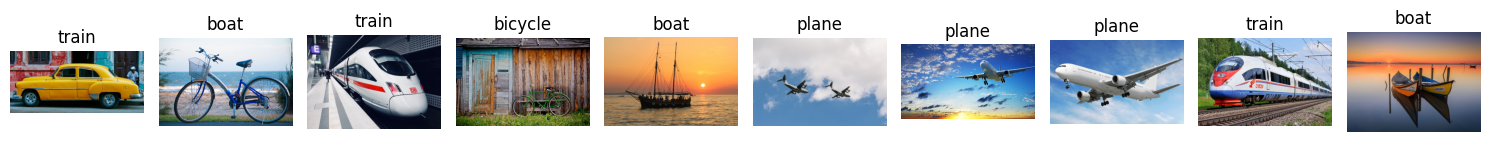

In [10]:
class_names = dataset.classes 

model = load_model(CNNModel(num_classes=len(class_names)), MODEL_PATH + "best_model_" + CNN_MODEL + ".pth")

for image_name in os.listdir(TEST_IMAGE_FOLDER):
    image_path = os.path.join(TEST_IMAGE_FOLDER, image_name)
    predicted_class = predict_image(model, image_path, class_names)
    # real_class = classes[int(image_name.split('.')[0]) - 1]
    print(f"Image: {image_name}, Predicted class: {predicted_class}, Class: real_class")


display_predictions(model, TEST_IMAGE_FOLDER, class_names)

### Визуализация эмбедингов

C:\Users\VVV\AppData\Local\Temp\ipykernel_14344\2184142066.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVI

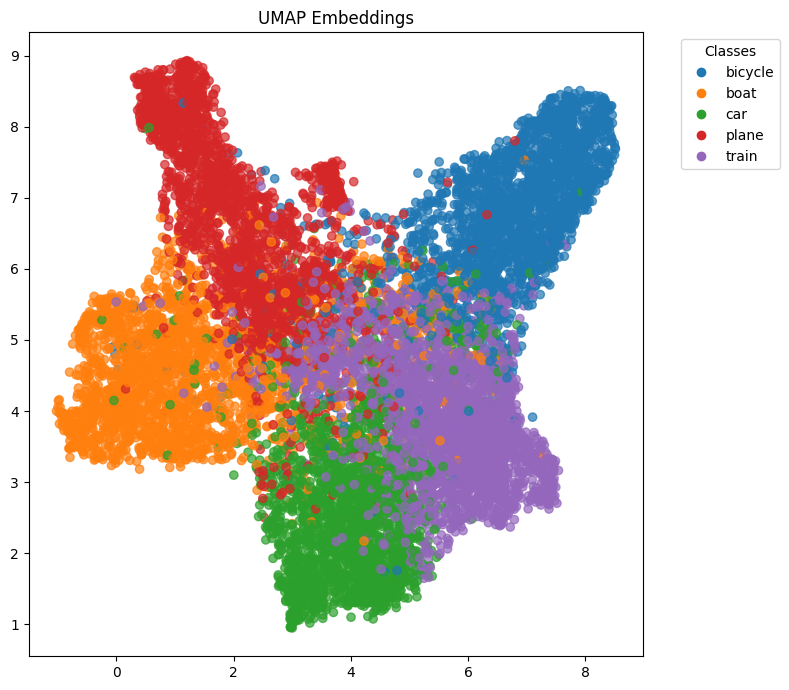

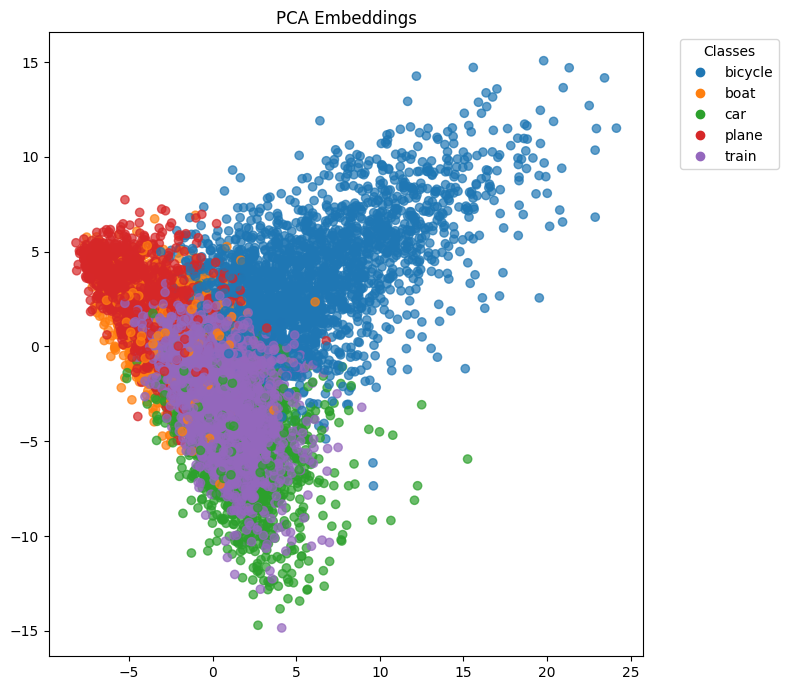

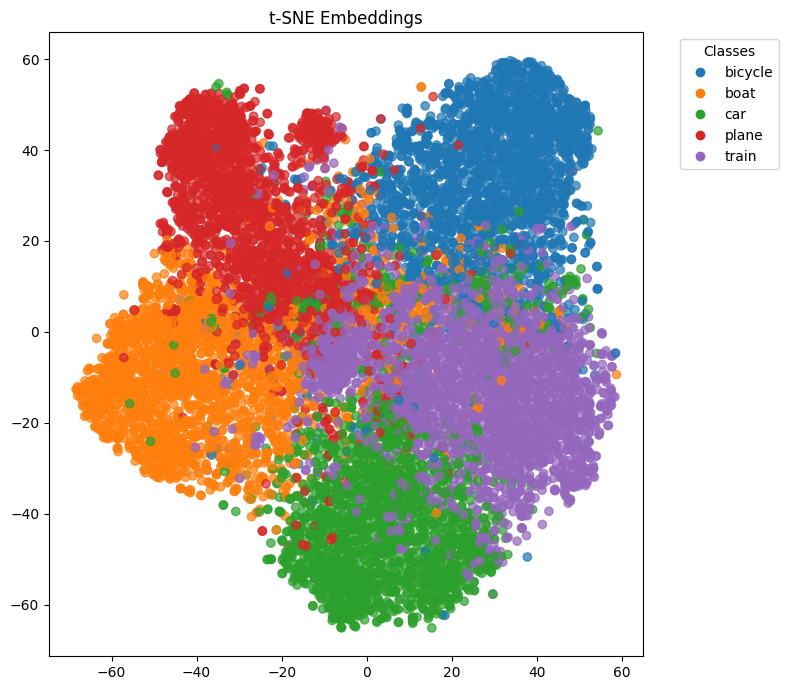

In [26]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

model = load_model(CNNModel(num_classes=len(dataset.classes)), MODEL_PATH + "best_model_" + CNN_MODEL + ".pth")

embeddings, labels = extract_embeddings(model, data_loader, DEVICE)

# Сохраняем эмбеддинги и визуализацию
os.makedirs(SAVE_PATH, exist_ok=True)
np.save(os.path.join(SAVE_PATH, "embeddings.npy"), embeddings)
np.save(os.path.join(SAVE_PATH, "labels.npy"), labels)

visualize_embeddings(embeddings, labels, classes=dataset.classes, save_path=SAVE_PATH)

## Transfer model

In [55]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes, fine_tune=False):
        super(TransferLearningModel, self).__init__()

        # Загружаем предобученную ResNet
        self.backbone = models.resnet18(pretrained=True)

        # Замораживаем параметры backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        if fine_tune:
            # Разморозка последних слоёв
            for param in self.backbone.layer3.parameters():
                param.requires_grad = True
            for param in self.backbone.layer4.parameters():
                param.requires_grad = True

        # Заменяем последний полносвязный слой
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),  # Новый линейный слой
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # Выходной слой для классификации
        )
        
        for param in self.backbone.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.backbone(x), torch.empty(0)


### Данные для ResNet

Изменим немного конфигурацию подгрузки датасета, т.к. ResNet обучена на других входных данных

In [27]:
# Преобразования изображений
TRANSFORMS = Compose([
    Resize((224, 224)),  # ResNet требует размер входа 224x224
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация ResNet
])

# Инициализация
dataset = ImageFolder(DATASET_PATH, transform=TRANSFORMS)
print(f"Классы: {dataset.classes}")
print(f"Число классов: {len(dataset.classes)}")

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
trash_size = len(dataset) - train_size - val_size - test_size

train_dataset, val_dataset, test_dataset, trash_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size, trash_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Классы: ['bicycle', 'boat', 'car', 'plane', 'train']
Число классов: 5


### Тренировка модели

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
writer = SummaryWriter(log_dir=LOG_DIR + "transfer_model_" + TRANSFER_MODEL)

start_time = time.time()
model = TransferLearningModel(num_classes=len(dataset.classes), fine_tune=True).to(DEVICE)


trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


train(model, train_loader, val_loader, criterion, optimizer, scheduler, writer, DEVICE, TRANSFER_MODEL)
transfer_learning_duration = time.time() - start_time
print(f"Transfer Learning Training Time: {transfer_learning_duration:.2f} seconds")

Trainable parameters: 10626053
Non-trainable parameters: 683072
Transfer Learning Training Time: 5425.80 seconds


> Transfer Learning Training Time: 5425.80 seconds

![transfer](./13.png)

Сколько бы я ни пытался, даже разблокируя последние 2 слоя для обучения, точность выше не становится. Но позже посмотрев пример из лекции, я понял, что это норма.


Как мы видим, наша CNN выполнялась 4247 секунд, а transfer модель выполнялась 5245 секунд, на 25% больше, на мой взгляд это не сильно существенно.
По точности, наша resnet обучается хуже, чем наша собственная модель. Наша модель обучается на 78% точности, когда ResNet имеет в 3 раза ниже показатель